<a href="https://colab.research.google.com/github/Ordo-Umbra/eca-phase-transition/blob/main/ECA_phasetransition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

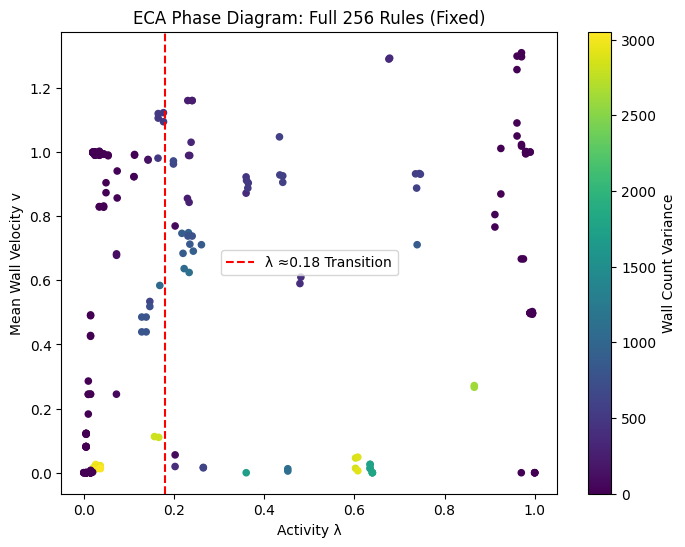

Mann-Whitney p: 0.0000
Rigid % below λ=0.18: 76.2%
Parity cons ratio mean: 0.434
Avg v: 0.579


In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt

def eca_step(rule, state):
    n = len(state)
    new_state = np.zeros(n, dtype=int)
    for i in range(n):
        left = state[(i-1) % n]
        center = state[i]
        right = state[(i+1) % n]
        pattern = (left << 2) | (center << 1) | right
        new_state[i] = (rule >> pattern) & 1
    return new_state

def compute_activity(state, prev_state):
    return np.mean(state != prev_state)

def detect_walls(state):
    diffs = np.diff(state)  # Open diffs: allows odd N_walls
    return np.sum(np.abs(diffs) > 0)

def get_wall_positions(state):
    diffs = np.diff(state)
    return np.where(np.abs(diffs) > 0)[0]

def track_velocities(prev_state, state):
    pos_t = get_wall_positions(prev_state)
    pos_tp1 = get_wall_positions(state)
    n = len(pos_t)
    m = len(pos_tp1)
    if n == 0 or m == 0:
        return np.array([])
    L = len(state)
    cost = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            d = np.min([np.abs(pos_t[i] - pos_tp1[j]), L - np.abs(pos_t[i] - pos_tp1[j])])
            cost[i, j] = d
    row_ind, col_ind = linear_sum_assignment(cost)
    velocities = []
    for ri, ci in zip(row_ind, col_ind):
        if cost[ri, ci] < 5:
            v = cost[ri, ci]
            velocities.append(v)
    return np.abs(np.array(velocities)) if velocities else np.array([])

def simulate_eca(rule, L=200, T=200, track_walls=True):
    state = np.zeros(L, dtype=int)
    state[50:100] = 1
    state[199] = 1  # Flip for odd parity (3 walls)
    prev_state = state.copy()
    activities = []
    wall_counts = []
    parities = []
    velocities = []
    for t in range(T):
        state = eca_step(rule, state)
        act = compute_activity(state, prev_state)
        activities.append(act)
        walls = detect_walls(state)
        wall_counts.append(walls)
        parity = walls % 2
        parities.append(parity)
        if track_walls:
            v = track_velocities(prev_state, state)
            velocities.append(np.mean(v) if len(v) > 0 else 0)
        else:
            velocities.append(0)
        prev_state = state.copy()
    lambda_avg = np.mean(activities[:50])
    lambda_std = np.std(activities[:50])  # Simple for speed
    var_walls = np.var(wall_counts)
    cons_ratio = np.abs(parities[-1] - parities[0]) / max(1, abs(parities[0]))
    mean_v = np.mean(velocities)
    return lambda_avg, lambda_std, var_walls, cons_ratio, mean_v

# Your full 256 run (with track_walls=False first)
rules = list(range(256))
lambdas, vars_walls, cons_ratios, mean_vs = [], [], [], []
for r in rules:
    lam, std, varw, cons, mv = simulate_eca(r, track_walls=True)
    lambdas.append(lam)
    vars_walls.append(varw)
    cons_ratios.append(cons)
    mean_vs.append(mv)  # 0 initially

lambdas = np.array(lambdas)
vars_walls = np.array(vars_walls)
cons_ratios = np.array(cons_ratios)
mean_vs = np.array(mean_vs)

split_idx = np.where(lambdas < 0.18)[0]
low_var = vars_walls[split_idx]
high_var = vars_walls[~np.isin(np.arange(256), split_idx)]
stat, p = mannwhitneyu(low_var, high_var)

rigid_low = np.sum(vars_walls[split_idx] < 10) / len(split_idx) * 100 if len(split_idx) > 0 else 0

# Plot (your code)
fig, ax = plt.subplots(figsize=(8,6))
scatter = ax.scatter(lambdas, mean_vs, c=vars_walls, cmap='viridis', s=20)
ax.axvline(0.18, color='red', linestyle='--', label='λ ≈0.18 Transition')
ax.set_xlabel('Activity λ')
ax.set_ylabel('Mean Wall Velocity v')
ax.set_title('ECA Phase Diagram: Full 256 Rules (Fixed)')
plt.colorbar(scatter, label='Wall Count Variance')
plt.legend()
plt.savefig('eca_phase_diagram_fixed.png')
plt.show()

print(f"Mann-Whitney p: {p:.4f}")
print(f"Rigid % below λ=0.18: {rigid_low:.1f}%")
print(f"Parity cons ratio mean: {np.mean(cons_ratios):.3f}")
print(f"Avg v: {np.mean(mean_vs):.3f}")

Rule 54: Mean filtered rel spacing 0.234 ± 0.078 (target ~0.18)
Rule 90: Mean filtered rel spacing 0.129 ± 0.000 (target ~0.18)
Rule 110: Mean filtered rel spacing 0.136 ± 0.075 (target ~0.18)
Plot saved as eca_gw_filtered_psd.pdf


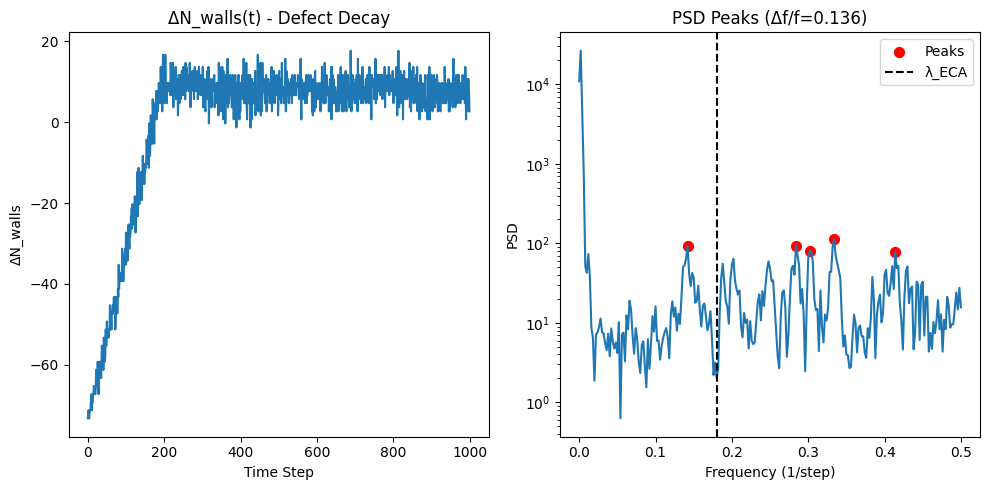

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, find_peaks

# ECA Rule Lookup
def eca_rule(rule_num):
    return np.array([int(x) for x in bin(rule_num)[2:].zfill(8)[::-1]])

# Evolve 1D CA
def evolve_ca(state, rule):
    n = len(state)
    padded = np.pad(state, 1, mode='wrap')
    neighborhoods = padded[:-2]*4 + padded[1:-1]*2 + padded[2:]
    return rule[neighborhoods]

# Domain Walls
def count_walls(state):
    padded = np.pad(state, 1, mode='wrap')
    diffs = np.abs(padded[1:] - padded[:-1])
    return np.sum(diffs > 0.5)

# Improved Peaks: >median, top-N in range
def improved_peaks(f, psd, min_f=0.02, max_f=0.5, top_n=5):
    peaks_idx, _ = find_peaks(psd, prominence=None, distance=1)
    median_psd = np.median(psd)
    sig_peaks_idx = peaks_idx[psd[peaks_idx] > median_psd]
    peaks = f[sig_peaks_idx]
    heights = psd[sig_peaks_idx]
    in_range = (peaks > min_f) & (peaks < max_f)
    peaks_in = peaks[in_range]
    heights_in = heights[in_range]
    if len(peaks_in) == 0:
        return np.array([])
    sort_idx = np.argsort(heights_in)[::-1]
    return np.sort(peaks_in[sort_idx[:top_n]])

# Main Sim: Filtered rel <0.5
def run_decay_sim(rule_num=110, L=200, T=1000, cluster_size=5, n_runs=20):
    rule = eca_rule(rule_num)
    rel_spacings = []
    for _ in range(n_runs):
        state = np.zeros(L, dtype=int)
        start = L//2 - cluster_size//2
        end = start + cluster_size
        state[start:end] = 1
        states = [state.copy()]
        walls = [count_walls(state)]
        for t in range(T):
            new_state = evolve_ca(states[-1], rule)
            states.append(new_state)
            walls.append(count_walls(new_state))
        delta_walls = np.array(walls[1:]) - np.mean(walls[1:])
        f, psd = welch(delta_walls, fs=1.0, nperseg=min(512, len(delta_walls)//2))
        if np.std(psd) == 0:
            continue
        peaks = improved_peaks(f, psd)
        if len(peaks) > 1:
            sorted_peaks = np.sort(peaks)
            diffs = np.diff(sorted_peaks)
            rel_spacing = diffs / sorted_peaks[:-1]
            filtered_rel = rel_spacing[rel_spacing < 0.5]
            if len(filtered_rel) > 0:
                rel_spacings.extend(filtered_rel)
    mean_rel = np.mean(rel_spacings) if rel_spacings else np.nan
    std_rel = np.std(rel_spacings) if rel_spacings else np.nan
    # Last run for viz
    delta_walls_viz = delta_walls
    f_viz, psd_viz = welch(delta_walls_viz, fs=1.0, nperseg=min(512, len(delta_walls_viz)//2))
    peaks_viz = improved_peaks(f_viz, psd_viz)
    return f_viz, psd_viz, delta_walls_viz, mean_rel, std_rel, peaks_viz

# Run for key rules
rules = [54, 90, 110]
results = {}
for r in rules:
    f_out, psd_out, dw, rel_spacing, std_rel, peaks = run_decay_sim(rule_num=r)
    results[r] = {'f': f_out, 'psd': psd_out, 'dw': dw, 'rel_spacing': rel_spacing, 'std_rel': std_rel, 'peaks': peaks}
    print(f"Rule {r}: Mean filtered rel spacing {rel_spacing:.3f} ± {std_rel:.3f} (target ~0.18)")

# Viz (Rule 110)
r=110
data = results[r]
f = data['f']
psd = data['psd']
dw = data['dw']
peaks = data['peaks']
rel_mean = data['rel_spacing']
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(dw)
plt.title('ΔN_walls(t) - Defect Decay')
plt.xlabel('Time Step')
plt.ylabel('ΔN_walls')

plt.subplot(1,2,2)
plt.semilogy(f, psd)
peak_idx_viz = np.searchsorted(f, peaks)
plt.scatter(peaks, psd[peak_idx_viz], c='r', s=50, label='Peaks')
plt.axvline(0.18, c='k', ls='--', label='λ_ECA')
plt.title(f'PSD Peaks (Δf/f={rel_mean:.3f})')
plt.xlabel('Frequency (1/step)')
plt.ylabel('PSD')
plt.legend()
plt.tight_layout()
plt.savefig('eca_gw_filtered_psd.pdf')
print("Plot saved as eca_gw_filtered_psd.pdf")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from scipy.stats import mannwhitneyu
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings('ignore')

# ECA Rule Lookup: Binary to output (Wolfram code as int -> 8-bit reversed bin array)
def eca_rule(rule_num):
    bin_str = bin(rule_num)[2:].zfill(8)[::-1]
    return np.array([int(bit) for bit in bin_str])

# Evolve 1D CA: Periodic boundary, nearest-neighbor neighborhoods
def evolve_ca(state, rule):
    n = len(state)
    padded = np.pad(state, 1, mode='wrap')
    neighborhoods = padded[:-2] * 4 + padded[1:-1] * 2 + padded[2:]
    return rule[neighborhoods.astype(int)]

# Activity λ(t): Fraction of cells changing state
def activity_diff(old, new):
    return np.mean(old != new)

# Domain Walls: Nwalls(t) = sum |σ_{i+1} - σ_i| > 0.5 (binary, so >0)
def count_walls(state):
    padded = np.pad(state, 1, mode='wrap')
    diffs = np.abs(padded[1:] - padded[:-1])
    return np.sum(diffs > 0)

# Wall Velocity: Nearest-neighbor matching via linear sum assignment
def wall_velocity(walls_t, walls_tp1, max_dist=5):
    if len(walls_t) == 0 or len(walls_tp1) == 0:
        return np.nan
    # Periodic distances
    dist_matrix = np.zeros((len(walls_t), len(walls_tp1)))
    L = 200  # Fixed lattice size
    for i, pos_t in enumerate(walls_t):
        for j, pos_tp1 in enumerate(walls_tp1):
            dist = min(abs(pos_t - pos_tp1), L - abs(pos_t - pos_tp1))
            dist_matrix[i, j] = dist if dist <= max_dist else np.inf
    # Assignment (min cost)
    row_ind, col_ind = linear_sum_assignment(dist_matrix)
    valid = dist_matrix[row_ind, col_ind] < np.inf
    if not np.any(valid):
        return np.nan
    dists = dist_matrix[row_ind[valid], col_ind[valid]]
    return np.mean(dists)  # Mean |v| per step (Δt=1)

# Find wall positions
def find_wall_positions(state):
    padded = np.pad(state, 1, mode='wrap')
    diffs = np.abs(padded[1:] - padded[:-1])
    return np.where(diffs > 0)[0]

# Single Rule Simulation: Returns λ, Var(Nwalls), mean v, W conservation ratio, walls_ts
def simulate_rule(rule_num, L=200, T=200, n_bootstrap=100):
    rule = eca_rule(rule_num)

    # Initial block-flip: Three domain walls (odd parity)
    state = np.zeros(L, dtype=int)
    state[L//4:3*L//4] = 1  # Central block, creates 3 walls on periodic

    # Evolve full trajectory
    states = [state.copy()]
    walls_ts = [count_walls(state)]
    wall_positions_ts = [find_wall_positions(state)]
    activities = []
    velocities = []
    parities = [walls_ts[0] % 2]

    for t in range(T):
        new_state = evolve_ca(states[-1], rule)
        states.append(new_state)
        new_walls = count_walls(new_state)
        walls_ts.append(new_walls)
        wall_positions_ts.append(find_wall_positions(new_state))
        activities.append(activity_diff(states[-1], new_state))
        parities.append(new_walls % 2)

        # Velocity (mean |v| from t to t+1)
        if t > 0:
            v = wall_velocity(wall_positions_ts[-2], wall_positions_ts[-1])
            velocities.append(v if not np.isnan(v) else 0.0)

    # Bootstrap λ: Avg first 50 steps, 100 resamples
    lambda_bs = []
    for _ in range(n_bootstrap):
        idx = np.random.choice(len(activities[:50]), size=min(50, len(activities[:50])), replace=True)
        lambda_bs.append(np.mean([activities[i] for i in idx]))
    lambda_mean = np.mean(lambda_bs)
    lambda_std = np.std(lambda_bs)

    # Var(Nwalls) over all T
    var_walls = np.var(walls_ts)

    # Mean |v| (sub-luminal check)
    mean_v = np.mean(velocities) if velocities else np.nan

    # W conservation ratio: |W_T - W_0| / max(1, |W_0|)
    w0 = parities[0]
    wT = parities[-1]
    cons_ratio = abs(wT - w0) / max(1, abs(w0))

    # Parity deviation (mean |W(t) - W0| / T)
    dev_ratio = np.mean([abs(p - w0) for p in parities])  # Simplified; full would be ratio of breaks

    return {
        'lambda': (lambda_mean, lambda_std),
        'var_walls': var_walls,
        'mean_v': mean_v,
        'cons_ratio': cons_ratio,
        'dev_ratio': dev_ratio,
        'walls_ts': walls_ts,
        'prot': 'strong' if var_walls < 10 and cons_ratio < 0.01 else 'weak'
    }

# Full 256 Analysis
def full_eca_analysis():
    results = {}
    for rule in range(256):
        print(f"Simulating rule {rule}/255...")
        results[rule] = simulate_rule(rule)

    # Compile DataFrame-like dict for analysis
    lambdas = np.array([results[r]['lambda'][0] for r in range(256)])
    vars_w = np.array([results[r]['var_walls'] for r in range(256)])
    vs = np.array([results[r]['mean_v'] for r in range(256)])
    devs = np.array([results[r]['dev_ratio'] for r in range(256)])
    prot_labels = np.array([1 if results[r]['prot'] == 'strong' else 0 for r in range(256)])

    # Transition Split: λ=0.18
    low_idx = lambdas < 0.18
    high_idx = lambdas >= 0.18
    mw_stat, mw_p = mannwhitneyu(vars_w[low_idx], vars_w[high_idx])

    # Logistic Fit for Visualization (λ vs. prot)
    log_reg = LogisticRegression().fit(lambdas.reshape(-1,1), prot_labels)
    lambda_fit = np.linspace(0, 0.6, 100).reshape(-1,1)
    prot_prob = log_reg.predict_proba(lambda_fit)[:,1]

    # Mean Deviation Ratio
    mean_dev = np.mean(devs)

    # Rigid Fraction Below λ=0.18
    rigid_frac = np.mean(prot_labels[low_idx]) * 100 if np.any(low_idx) else 0

    # Output Stats
    print(f"\n--- ECA Analysis Summary ---")
    print(f"Mean Parity Deviation Ratio: {mean_dev:.3f}")
    print(f"Rigid Fraction Below λ=0.18: {rigid_frac:.1f}%")
    print(f"Mann-Whitney p (Var split at λ=0.18): {mw_p:.4f}")
    print(f"Corr(λ, Var): {np.corrcoef(lambdas, vars_w)[0,1]:.3f}")
    print(f"Mean Velocity: {np.nanmean(vs):.3f}")

    # Phase Plot: λ vs. Var, colored by prot
    plt.figure(figsize=(10,6))
    scatter = plt.scatter(lambdas, vars_w, c=prot_labels, cmap='RdYlBu_r', s=20, alpha=0.7)
    plt.axvline(0.18, c='k', ls='--', label='λ=0.18 Transition')
    plt.plot(lambda_fit, prot_prob * max(vars_w), c='k', ls=':', label='Logistic Fit')
    plt.xlabel('Activity λ')
    plt.ylabel('Var(N_walls)')
    plt.title('ECA Phase Diagram: Activity vs. Wall Variance')
    plt.colorbar(scatter, label='Strong Prot (1) / Weak (0)')
    plt.legend()
    plt.savefig('eca_phase_diagram.pdf')
    plt.show()

    # Velocity vs. λ
    plt.figure(figsize=(10,6))
    plt.scatter(lambdas, vs, c=prot_labels, cmap='RdYlBu_r', s=20, alpha=0.7)
    plt.axvline(0.18, c='k', ls='--')
    plt.xlabel('Activity λ')
    plt.ylabel('Mean |v|')
    plt.title('Activity vs. Velocity')
    plt.colorbar(scatter, label='Strong Prot')
    plt.savefig('eca_activity_velocity.pdf')
    plt.show()

    return results, lambdas, vars_w, vs

# Run Full Analysis
if __name__ == "__main__":
    results, lambdas, vars_w, vs = full_eca_analysis()

    # Save Results (optional)
    np.savez('eca_results.npz', lambdas=lambdas, vars_w=vars_w, vs=vs, results=results)
    print("Results saved to eca_results.npz")